In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

Merging two datasets into one master dataset. 

In [2]:
df1 = pd.read_csv('train_data.csv')
df2 = pd.read_csv('test_data.csv')
df = pd.concat([df1, df2])

In [3]:
df.head(10)

,Unnamed: 0,Sentence_id,New_Sentence,Type
0,0,GERRES15609,Author and/or Review architecture/design and o...,Responsibility
1,1,PHERES15784,Should be able to develop custom dynamic shape...,Responsibility
2,2,GERREQ10457,Experience in working crosslly with a larger ...,Requirement
3,3,GERSKL27235,"Previous business experience, including but no...",Skill
4,4,HONSSK18415,Delivering fast and right the first time.,SoftSkill
5,5,INDRES9494,Track department expenses and capital budget .,Responsibility
6,6,HONRES51852,Meet performance metrics.,Responsibility
7,7,UAEREQ34683,YOU MUST HAVEBachelors degree in Engineering.,Requirement
8,8,UAEREQ4612,After COVID-19: Ability to travel to manufactu...,Requirement
9,9,INDEDU42721,Six Sigma qualification to at least Green Bel...,Education


In [4]:
df.describe()

,Unnamed: 0
count,75144.000000
mean,25548.340001
std,18055.461497
min,0.000000
25%,9392.750000
50%,22542.500000
75%,41328.250000
max,60114.000000


Number of tuples per each type

In [5]:
df.isna().sum()

Unnamed: 0          0
Sentence_id         0
New_Sentence     1394
Type            15029
dtype: int64

In [6]:
df = df.dropna( how='any',subset=['Type','New_Sentence'])

In [7]:
df.isna().sum()

Unnamed: 0      0
Sentence_id     0
New_Sentence    0
Type            0
dtype: int64

Text(0, 0.5, 'Count')

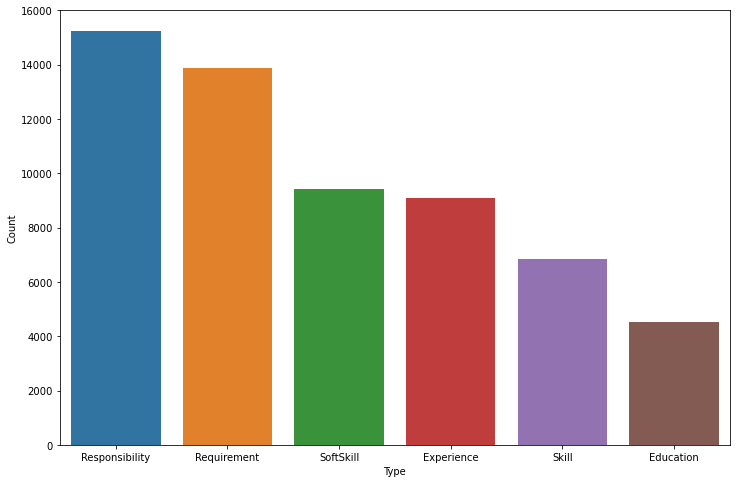

In [8]:
plt.figure(figsize=(12,8))
count = df.Type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Type')
plt.ylabel('Count')

Splitting data into train validation test.

In [9]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [10]:
print("The length of train data is : ",len(train), "\nThe length of validate data is :",len(validate),"\nThe length of test data is : ",len(test))

The length of train data is :  35401 
The length of validate data is : 11800 
The length of test data is :  11801


In [11]:
train.describe()

,Unnamed: 0
count,35401.000000
mean,30094.207367
std,17373.403834
min,1.000000
25%,15090.000000
50%,30080.000000
75%,45172.000000
max,60114.000000


In [12]:
train['Type'].value_counts()

Responsibility    9304
Requirement       8271
SoftSkill         5629
Experience        5356
Skill             4094
Education         2747
Name: Type, dtype: int64

Text(0, 0.5, 'Count')

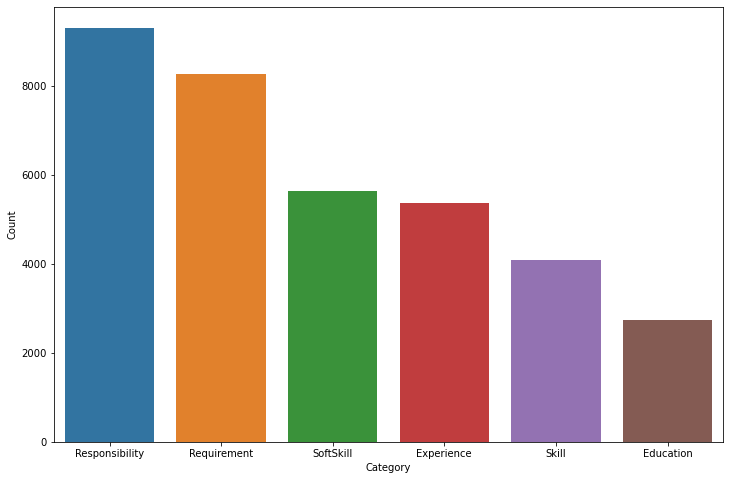

In [13]:
plt.figure(figsize=(12,8))
count = train.Type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Category')
plt.ylabel('Count')

Getting a list of stopwords from nltk library

In [14]:
sw_nltk = stopwords.words('english')

REF https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

Counting the number of times, each word has appeared throughout the dataset by creating a dictionary for frequency count of words in the dataset.

In [15]:
def word_counts(data_set) -> list:
    words_in_tuple = dict()
    text = data_set['New_Sentence']
    text = text.to_string()
    text = text.strip()
    text = text.lower()
    
    #words = [word for word in text.split(' ') if word not in sw_nltk]
    words = text.split(' ')
    #print(len(words))
    
    for word in words:
        if word == ' ' or word.isnumeric() == True:
            continue
        if word in words_in_tuple:
              words_in_tuple[word] = words_in_tuple[word] + 1
        else:
              words_in_tuple[word] = 1  
    for key in list(words_in_tuple.keys()):  ## creates a list of all keys
      if words_in_tuple[key] < 5:
        del words_in_tuple[key] 
       
    return (words_in_tuple)
vocab = word_counts(train)
print(len(vocab))

2867


In [16]:
#Conditional count of the words for every label 
# Refrenece blog : https://taherparatha.wordpress.com/portfolio/classifying-news-articles-using-naive-bayes-classifier-from-scratch/
import re
Types = df['Type'].unique()
def conditional_count_values(dataset,label):  
  word_count = {}
  for typ in Types:
    word_dict = {}
    data = df[df[label] == typ]['New_Sentence']
    for row in data:
      words = list(set(re.split("[^a-zA-Z]",str(row))))
      for word in words:
        word = word.lower()
        if word in word_dict:
          word_dict[word] = word_dict[word]+1
        else:
          word_dict[word] = 1
    for word, count in dict(word_dict).items():
      if (len(word)<3) or (count<=5):
        word_dict.pop(word)
    word_count[typ] = word_dict
  
  return pd.DataFrame(word_count).fillna(0)

temp = conditional_count_values(train,"Type")
print(temp)

              Responsibility  Requirement  Skill  SoftSkill  Education  \
deliverables           103.0         27.0    0.0       16.0        0.0   
other                  515.0        225.0  149.0       84.0      124.0   
architecture           192.0        146.0   93.0       31.0       32.0   
high                   239.0        229.0   69.0      229.0      109.0   
applications           232.0        198.0  143.0       17.0       29.0   
...                      ...          ...    ...        ...        ...   
jaar                     0.0          0.0    0.0        0.0        0.0   
heavy                    0.0          0.0    0.0        0.0        0.0   
ado                      0.0          0.0    0.0        0.0        0.0   
poste                    0.0          0.0    0.0        0.0        0.0   
semi                     0.0          0.0    0.0        0.0        0.0   

              Experience  
deliverables         9.0  
other              121.0  
architecture       133.0  
hig

In [17]:
#returns the probability of the word with total number of docs.
def probability_of_word_in_all_documents(dataset,word_given,smoothing):
  return((word_counts(dataset)[word_given] + smoothing )/(len(dataset) + (len(dataset['Type'].unique()) * smoothing)))

In [18]:
#conditional probability value
def conditional_probability(dataset,word,category,smoothing):
  conditional_value_dataframe = conditional_count_values(train,'Type')
  probability_value = (conditional_value_dataframe.loc[word,category])*smoothing / ((conditional_value_dataframe[category].sum()) + (smoothing * len(conditional_value_dataframe[category])))
  return probability_value

In [19]:
def count_probability_class(category_set):
  result_probabilty = train.groupby('Type').size().div(len(train)) #count()['category']/len(category)
  return(result_probabilty)

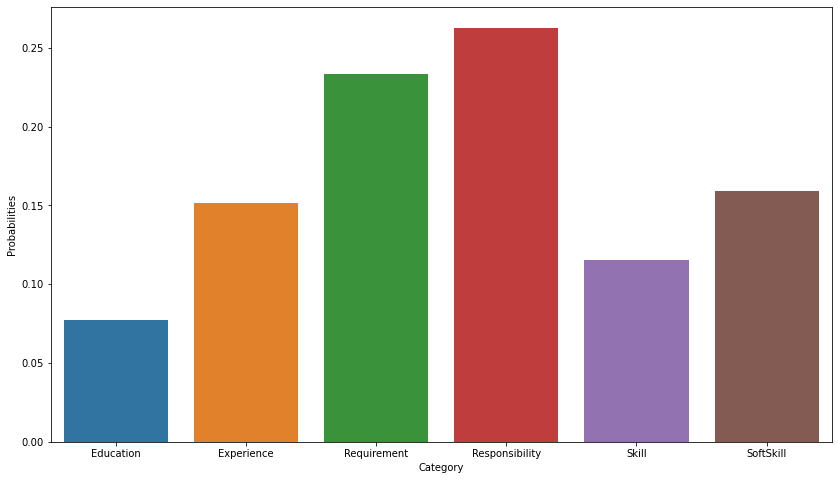

In [20]:
result_probabilty = train.groupby('Type').size().div(len(train)) #count()['category']/len(category)
plt.figure(figsize=(14,8))
sns.barplot(x=result_probabilty.index, y=result_probabilty)
plt.xlabel('Category')
plt.ylabel('Probabilities')
plt.show()

In [21]:
def nb_probability(word,data,category,smoothing):
  final_prob = conditional_probability(data,word,category,smoothing) * count_probability_class(train)
  print(final_prob[category])
  return final_prob[category]

# TRAINING THE DATASET.

In [22]:
vocab_train = word_counts(train)
cond_words_train = conditional_count_values(train,'Type')
cond_words_train.dropna()

,Responsibility,Requirement,Skill,SoftSkill,Education,Experience
deliverables,103.0,27.0,0.0,16.0,0.0,9.0
other,515.0,225.0,149.0,84.0,124.0,121.0
architecture,192.0,146.0,93.0,31.0,32.0,133.0
high,239.0,229.0,69.0,229.0,109.0,87.0
applications,232.0,198.0,143.0,17.0,29.0,216.0
...,...,...,...,...,...,...
jaar,0.0,0.0,0.0,0.0,0.0,6.0
heavy,0.0,0.0,0.0,0.0,0.0,7.0
ado,0.0,0.0,0.0,0.0,0.0,6.0
poste,0.0,0.0,0.0,0.0,0.0,6.0


Finding the probability of the word “teams“.

In [23]:
probability_of_word_in_all_documents(train,"teams",1)  

0.005337927528454825

Calculating the Naive Bayes probability of the word “teams” across every category



In [24]:
class_train_probability = count_probability_class(train)
for i in train['Type'].unique():
  print(nb_probability("teams",train,i,0.1))

2.7294017732565873e-05
2.7294017732565873e-05
6.407608317412349e-05
6.407608317412349e-05
9.51044627671153e-05
9.51044627671153e-05
1.3352694495535953e-05
1.3352694495535953e-05
6.806541782670876e-05
6.806541782670876e-05
4.244909374550203e-06
4.244909374550203e-06


TESTING THE DATASET


In [25]:
vocab_test = word_counts(test)
cond_words_test = conditional_count_values(test,'Type')
cond_words_test.dropna()

,Responsibility,Requirement,Skill,SoftSkill,Education,Experience
deliverables,103.0,27.0,0.0,16.0,0.0,9.0
other,515.0,225.0,149.0,84.0,124.0,121.0
architecture,192.0,146.0,93.0,31.0,32.0,133.0
high,239.0,229.0,69.0,229.0,109.0,87.0
applications,232.0,198.0,143.0,17.0,29.0,216.0
...,...,...,...,...,...,...
jaar,0.0,0.0,0.0,0.0,0.0,6.0
heavy,0.0,0.0,0.0,0.0,0.0,7.0
ado,0.0,0.0,0.0,0.0,0.0,6.0
poste,0.0,0.0,0.0,0.0,0.0,6.0


In [26]:
class_test_probability = count_probability_class(test)
class_test_probability

Type
Education         0.077597
Experience        0.151295
Requirement       0.233637
Responsibility    0.262817
Skill             0.115646
SoftSkill         0.159007
dtype: float64

In [27]:
for i in test['Type'].unique():
  print(nb_probability("teams",test,i,0.1))

9.51044627671153e-05
9.51044627671153e-05
6.407608317412349e-05
6.407608317412349e-05
6.806541782670876e-05
6.806541782670876e-05
1.3352694495535953e-05
1.3352694495535953e-05
2.7294017732565873e-05
2.7294017732565873e-05
4.244909374550203e-06
4.244909374550203e-06
